In [6]:
import pickle

from src.generative_model import GenerativeModel
from src.machine_learning import PredictionModel
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
PRED_MODEL = PredictionModel(base_learners_pickle_path='../drive_data/pickles/base_learner_pickles/',
                             meta_learner_pickle_path='../drive_data/pickles/meta_learner_pickles/')
with open('../data/resistance_bounds.pkl', 'rb') as f:
    RES_BOUNDS = pickle.load(f)

RES_BOUNDS_DF = pd.DataFrame(RES_BOUNDS)
# Make transposed version of the dataframe
RES_BOUNDS_DF = RES_BOUNDS_DF.T
RES_BOUNDS_DF

,Width,Height,Fillet_Radius,lb,ub,avg,div_res
0,0.05,0.05,0.03,6.96,124.80,65.88,3.41
1,0.05,0.05,0.04,6.95,124.55,65.75,3.41
2,0.05,0.05,0.05,6.95,124.33,65.64,3.41
3,0.05,0.06,0.03,4.85,86.99,45.92,2.38
4,0.05,0.06,0.04,4.85,86.81,45.83,2.37
...,...,...,...,...,...,...,...
187,0.20,0.15,0.16,0.05,0.90,0.47,0.02
188,0.20,0.15,0.20,0.05,0.89,0.47,0.02
189,0.20,0.20,0.12,0.03,0.48,0.25,0.01
190,0.20,0.20,0.16,0.03,0.48,0.25,0.01


In [8]:
def show_convergence(resistence_info_list: list[tuple[float, float, float, float, str]],
                     prediction_model: PredictionModel,
                     resistance_bounds: dict) -> list[dict]:
    """
    Shows the convergence of the generative model
    :param resistence_info_list: list of tuples of resistence information (desired_resistance, width, height, fillet_radius, target_loc_mode)
    :param prediction_model: PredictionModel object
    :param resistance_bounds: dictionary of resistance bounds
    :return: None
    """

    all_iters = []
    for resistence_info in resistence_info_list:
        desired_res, width, height, fillet_radius, target_loc_mode = resistence_info
        try:
            generative_model = GenerativeModel(prediction_model=prediction_model,
                                               resistance_bounds_dict=resistance_bounds,
                                               desired_resistance=desired_res,
                                               step_size_factor=0.5,
                                               width=width,
                                               height=height,
                                               fillet_radius=fillet_radius,
                                               target_loc_mode=target_loc_mode,
                                               method='TS',
                                               side_length=20,
                                               time_limit=30,
                                               plot_bool=False,
                                               print_iteration=False)
            _, costs = generative_model.generate_maze()
            all_iters.append({"resistence_info": resistence_info, "costs": costs})
            print(f"Finished resistence_info: {resistence_info}")
        except Exception as e:
            print(f"Error for resistence_info: {resistence_info}")
            print(e)

    return all_iters

In [9]:
ALL_ITERATIONS = show_convergence([(100, 0.05, 0.05, 0.03, 'north'),
                                   (20, 0.07, 0.06, 0.07, 'east'),
                                   (60, 0.05, 0.05, 0.03, 'north'),
                                   (2, 0.10, 0.09, 0.08, 'east'),
                                   (10, 0.07, 0.06, 0.07, 'north')],
                                   PRED_MODEL,
                                   RES_BOUNDS)

Finished resistence_info: (100, 0.05, 0.05, 0.03, 'north')
Finished resistence_info: (20, 0.07, 0.06, 0.07, 'east')
Finished resistence_info: (60, 0.05, 0.05, 0.03, 'north')
Finished resistence_info: (2, 0.1, 0.09, 0.08, 'east')
Finished resistence_info: (10, 0.07, 0.06, 0.07, 'north')


In [10]:
ALL_ITERATIONS_DF = pd.DataFrame(columns=[i for i in range(len(ALL_ITERATIONS))])
LONGEST_ITER = max([len(res_info['costs']) for res_info in ALL_ITERATIONS])
for i, res_info in enumerate(ALL_ITERATIONS):
    ALL_ITERATIONS_DF[i] = res_info['costs'] + [res_info['costs'][-1]]*(LONGEST_ITER - len(res_info['costs']))

# drop the rows that has the same values
LAST_ROW = ALL_ITERATIONS_DF.iloc[-1]
for i in range(len(ALL_ITERATIONS_DF) - 2, -1, -1):
    if ALL_ITERATIONS_DF.iloc[i].equals(LAST_ROW):
        ALL_ITERATIONS_DF.drop(i, inplace=True)

ALL_ITERATIONS_DF.reset_index(drop=True, inplace=True)
ALL_ITERATIONS_DF

,0,1,2,3,4
0,26.35,25.72,68.35,13.88,36.43
1,0.78,3.84,14.55,3.97,17.23
2,0.49,0.29,0.03,1.85,4.05
3,0.29,0.03,0.03,0.93,0.82
4,0.05,0.03,0.03,0.62,0.66
5,0.05,0.03,0.03,0.00,0.05


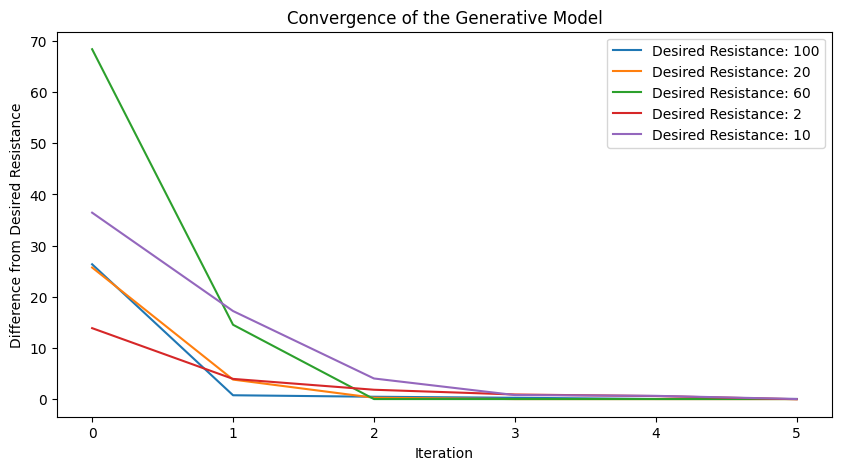

In [11]:
# plot the convergences of the generative model use the new indices
plt.figure(figsize=(10, 5))
for i in range(len(ALL_ITERATIONS_DF.columns)):
    plt.plot(ALL_ITERATIONS_DF[i], label=f"Desired Resistance: {ALL_ITERATIONS[i]['resistence_info'][0]}")
plt.xticks(range(len(ALL_ITERATIONS_DF)))
plt.xlabel("Iteration")
plt.ylabel("Difference from Desired Resistance")
plt.title("Convergence of the Generative Model")
plt.legend()
plt.show()